In [2]:
# Plot Results Script
# I-Kai Chen, Marius Kongsore, Ken Van Tilburg
# December 2022

# This file as part of a larger GitHub package
# https://github.com/mkongsore/BlipFinder

# Import system packages
import sys
import os

# Import public packages
import scipy 
import pandas as pd
import numpy as np
from pymultinest.solve import Solver

# Import BlipFinder analysis functions
import analysis_fcns # Import the analysis functions script
import constraint_fcns # Import the constraint functions script

# Import plotting scripts
import matplotlib as mpl
from matplotlib import pyplot as plt
import corner

# Initialize functions for statistical analysis ('black_holes' is a placeholder)
analysis = analysis_fcns.blip_search('black_holes')

# Initialize constraint functions
blip_constraints = constraint_fcns.cons_blip # Tuple of functions contraining blip model fitting

# Import fcns scripts
import dynamics_fcns # Import the dynamics functions script
import bh_prior_fcns # Import the black hole prior functions script

# Change system path
sys.path.append('../')

# Import BlipFinder dynamics and prior functions
dynamics = dynamics_fcns.Dynamics() # Functions for stellar and lens motion
priors = bh_prior_fcns.BH_priors() # Functions for black hole priors

# Load file containing time and scan angle information for all observations
obs_info = pd.read_csv('./obs_info.csv', sep=",") # Read observation info csv

# Obtain general Gaia observation info from obs_info file
t_obs = obs_info['Observation Times [Julian Year]'].to_numpy() # Observation times [Julian years]
scan_angles = obs_info['Scan Angles [rad]'].to_numpy() #  Scan angles [rad]
t_ref = 2017.5 # Reference time for calculating displacement [Julian years]

In [3]:
plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc

cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
plt.rcParams['font.serif']=cmfont.get_name()
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.size" : fontsize,
          "text.usetex" : False,
          "mathtext.fontset" : "cm",
          "font.family" : "serif",
          "font.serif" : [cmfont.get_name()]}
plt.rcParams['axes.unicode_minus']=False
plt.rcParams.update(params)

In [4]:
catalog_list = os.listdir('./Data')

source_id: 5728504125199143468


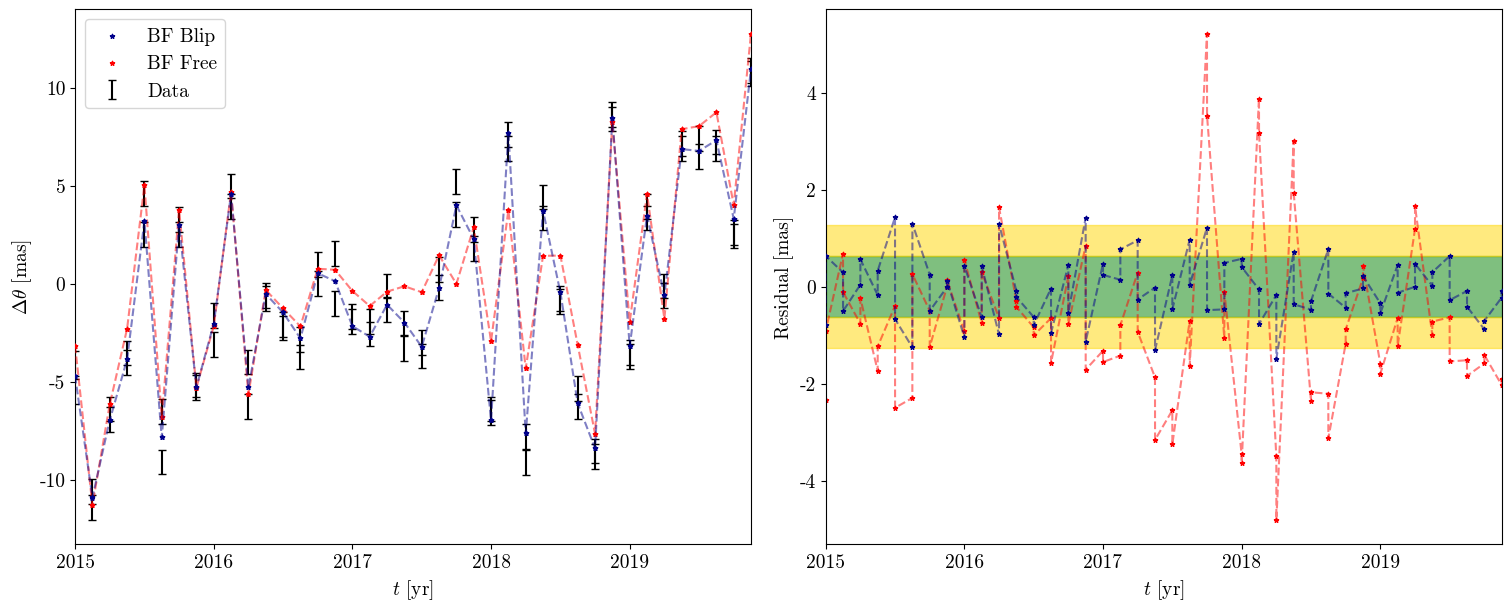

Catalog Number: 650893-651194
Source ID: 5728504125199143468

*Statistics*
TS*: 619.8414164637883
Free -2LL: 702.8233039560838
Accel -2LL: 478.30297343172805

*BF Blip Parameters*
Source deltaRA [mas]: -0.1603708137980404
Source deltaDEC [mas]: -0.05547876381892945
Source PMRA [mas/yr]: -4.696071686338742
Source PMDEC [mas/yr]: -1.0403855555554722
Source dist [pc]: 1438.1993353657626
Lens deltaRA [mas]: 1.8530454668719496
Lens deltaDEC [mas]: 39.639997863812134
Lens PMRA [mas/yr]: 11.103941352200847
Lens PMDEC [mas/yr]: -51.67108542372369
Lens dist [pc]: 414.80629765889665
Lens mass [SM]: 13.03318404567841


In [23]:
results_list = os.listdir('./Results/BlipMultinest')
for m,catalog_name in enumerate(results_list):

    catalog_number = str(catalog_name)[5:18]
        
    catalog_name = 'gaia_epoch_'+catalog_number+'.pkl'

    catalog_info_name = 'gaia_info_'+catalog_number+'.csv'

    data = pd.read_pickle('./Data/'+catalog_name) 
    catalog_id_list = list(data['source_id'])
    
    misc_info_data = pd.read_csv('./SourceInfo/'+catalog_info_name) # Load in file containing parallax and g magnitude information
        
    results = pd.read_csv('./Results/BlipMultinest/blip_'+catalog_number+'.csv')
    free_results = pd.read_csv('./Results/FreeMultinest/free_'+catalog_number+'.csv')
    accel_results = pd.read_csv('./Results/AccelMultinest/accel_'+catalog_number+'.csv')
    for m in range(np.size(results['s_id'])):
        
        results_row = results.iloc[m]
        source_id = results.iat[m,0]

        print('source_id:',source_id)

        x0 = results_row[1]
        x1 = results_row[2]
        x2 = results_row[3]
        x3 = results_row[4]
        x4 = results_row[5]
        x5 = results_row[6]
        x6 = results_row[7]
        x7 = results_row[8]
        x8 = results_row[9]
        x9 = results_row[10]
        x10 = results_row[11]
        blip_ts = -results_row[12]
                
        x = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])
        
        source_idx = catalog_id_list.index(source_id)
        source_row = data.iloc[source_idx] # Pick particular RA row corresponding to source of interest
        source_info_row = misc_info_data.iloc[source_idx] # Pick the particular data file row corresponding to the source of interest
    
        free_results_row = free_results.iloc[m]
    
        y0 = free_results_row[1]
        y1 = free_results_row[2]
        y2 = free_results_row[3]
        y3 = free_results_row[4]
        y4 = free_results_row[5]
        free_2ll = -free_results_row[6]
        
        y = np.array([y0,y1,y2,y3,y4])
        
        accel_results_row = accel_results.iloc[m]
        
        z0 = accel_results_row[1]
        z1 = accel_results_row[2]
        z2 = accel_results_row[3]
        z3 = accel_results_row[4]
        z4 = accel_results_row[5]
        z5 = accel_results_row[6]
        z6 = accel_results_row[7]
        accel_2ll = -accel_results_row[8]
        
        source_id = data.iat[source_idx,0] # Specify the source ID
        source_ra0 = float(source_row[1]) # RA of source at first observation epoch [deg]
        source_dec0 = float(source_row[2]) # DEC of source at first observation epoch [deg]
        source_ddefl_noerr = np.array(source_row[3:]) # Change in RA [mas]
        source_dist = float(source_info_row[3]) # Estimated distance to source [pc]
        source_gmag = float(source_info_row[6]) # G magntiude of source
        
        d_ra_l = (x[5]-x[0])/3600/1000/np.cos(source_dec0*np.pi/180) # [deg]
        d_dec_l = (x[6]-x[1])/3600/1000 # [deg]
        
        seed_info = pd.read_csv('./SourceInfo/'+catalog_number+'_seeds.csv')
        
        np.random.seed(int(seed_info.iat[source_idx,2])) # Set a random seed to ensure data gets scrambled in the same way every time, based on the source distance
        
        source_ddefl_err = analysis.disp_err(source_gmag)
        source_ddefl = source_ddefl_noerr
        source_ddefl = np.random.normal(loc = source_ddefl_noerr,scale = source_ddefl_err) # Scramble data according to a normal distribution with 1 sigma = source_ddec_err [mas]
        
        ddefl = source_ddefl
        err = source_ddefl_err
        
        ra0 = source_ra0
        dec0 = source_dec0
            
        # Extract model parameters from parameter array
        d_ra_l = x[5]/3600/1000/np.cos(dec0*np.pi/180) # [deg]
        d_dec_l = x[6]/3600/1000 # [deg]
        
        # Compute the AL location of the source according to the lensed model
        al_traj = dynamics.lensed_AL(ra0,dec0,x[2],x[3],x[4],
            ra0+d_ra_l,dec0+d_dec_l,x[7],x[8],x[9],x[10]) # [mas]
        
        # Compute the AL offset
        al_offset = np.sin(scan_angles)*x[0]+np.cos(scan_angles)*x[1] # [mas]
        
        # Compute the difference in AL coordinates between the data and the unlensed model
        sl_ddefl = al_traj+al_offset # [mas]
        
        al_nolens_offset = np.sin(scan_angles)*x[0]+np.cos(scan_angles)*x[1] # [mas]
        al_no_lens_offset = np.sin(scan_angles)*y[0]+np.cos(scan_angles)*y[1] # [mas]
        
        nolens_ddefl = dynamics.unlens_AL(ra0,dec0,x[2],x[3],x[4]) + al_nolens_offset 
        no_lens_ddefl = dynamics.unlens_AL(ra0,dec0,y[2],y[3],y[4]) + al_no_lens_offset 
        
        parallax = (1/x[4])*1000
        mura = x[2]
        mudec = x[3]
        alphadeg = ra0
        deltadeg = dec0
            
        ############
        ############
        
        # Unlensed log likelihood
        twoll_no_lens = analysis.free_2ll(source_ddefl,source_ddefl_err,ra0,dec0,y)
        
        # Lensed 
        
        ts = results_row[12]
        ts_lens = analysis.llr(source_ddefl,source_ddefl_err,twoll_no_lens,ra0,dec0,x)
                                                                
        postsamples = np.load('./Results/BlipPostsamples/post_'+str(catalog_number)+'_'+str(source_id)+'.npz')    
        
        fig, axd = plt.subplot_mosaic([['left', 'right']],
                  figsize=(15, 6), constrained_layout=True)
        
        axd['left'].errorbar(t_obs,source_ddefl,np.ones(80)*source_ddefl_err,color='black',label='Data',alpha=1.0,linestyle='',capsize=3, elinewidth=1.5,zorder=0)
        #ax_lens.plot(t_obs,nolens_ddefl,color='lightsteelblue',label='BF Source Path',linestyle='--')
        
        axd['left'].scatter(t_obs,sl_ddefl,color = 'darkblue',marker='*',zorder=21,s=10,label='BF Blip')
        axd['left'].scatter(t_obs,no_lens_ddefl,color='red',alpha=1.0,marker='*',zorder=10,s=10,label='BF Free')  
        
        axd['left'].plot(t_obs,no_lens_ddefl,color='red',linestyle='--',alpha=0.5,zorder=9)            
        axd['left'].plot(t_obs,sl_ddefl,color = 'darkblue',linestyle='--',alpha=0.5,zorder=20)
        
        axd['left'].set_xlabel(r'$t$ [yr]')
        axd['left'].set_ylabel(r'$\Delta \theta$ [mas]')
        axd['left'].set_xlim(t_obs[0],t_obs[-1])
    
        axd['right'].set_xlabel('$t$ [yr]')
        axd['right'].set_ylabel('Residual [mas]')
        axd['right'].fill_between(t_obs,-1*source_ddefl_err[0],1*source_ddefl_err[0],color='green',alpha=0.5)
        axd['right'].fill_between(t_obs,1*source_ddefl_err[0],2*source_ddefl_err[0],color='gold',alpha=0.5)
        axd['right'].fill_between(t_obs,-2*source_ddefl_err[0],-1*source_ddefl_err[0],color='gold',alpha=0.5)

        axd['right'].scatter(t_obs,(source_ddefl-sl_ddefl),color='darkblue',marker='*',zorder=21,s=10)
        axd['right'].plot(t_obs,(source_ddefl-sl_ddefl),color='darkblue',linestyle='--',alpha=0.5,zorder=20)
    
        axd['right'].scatter(t_obs,(source_ddefl-no_lens_ddefl),color='red',marker='*',s=10)
        axd['right'].plot(t_obs,(source_ddefl-no_lens_ddefl),color='red',linestyle='--',alpha=0.5)
        axd['right'].set_xlim(t_obs[0],t_obs[-1])
        
        axd['left'].legend()
        
        plt.show()
        
        print('Catalog Number:',catalog_number)
        print('Source ID:',source_id)
        print('')
        print('*Statistics*')
        print('TS*:',blip_ts)
        print('Free -2LL:',-free_2ll)
        print('Accel -2LL:',-accel_2ll)
        print('')
        print('*BF Blip Parameters*')
        print('Source deltaRA [mas]:',x[0])
        print('Source deltaDEC [mas]:',x[1])
        print('Source PMRA [mas/yr]:',x[2])
        print('Source PMDEC [mas/yr]:',x[3])
        print('Source dist [pc]:',x[4])
        print('Lens deltaRA [mas]:',x[5])
        print('Lens deltaDEC [mas]:',x[6])
        print('Lens PMRA [mas/yr]:',x[7])
        print('Lens PMDEC [mas/yr]:',x[8])
        print('Lens dist [pc]:',x[9])
        print('Lens mass [SM]:',x[10])

        